---
title: 3 Layer Stacked QG Model
subject: Jax Approximate Ocean Models
# subtitle: How can I estimate the state AND the parameters?
short_title: Stacked QG
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
  - name: Takaya Uchida
    affiliations:
      - FSU
    orcid: https://orcid.org/0000-0002-8654-6009
    email: roxyboy.guppy@gmail.com
license: CC-BY-4.0
keywords: jax, shallow water model, differentiable
abbreviations:
    SW: Shallow Water
    QG: Quasi-Geostrophic
    PDE: Partial Differential Equation
    RHS: Right Hand Side
---

In [1]:
import jax
import jax.numpy as jnp

# Global flag to set a specific platform, must be used at startup.
jax.config.update('jax_platform_name', 'cpu')

In [2]:
import autoroot
import typing as tp
import equinox as eqx 
from fieldx._src.domain.domain import Domain
import einops

import math
import diffrax as dfx
from jaxtyping import Array, Float
import numpy as np
import jax.scipy as jsp
from jax.config import config
import pandas as pd
from finitevolx import (
    laplacian, divergence, geostrophic_gradient, x_avg_2D, y_avg_2D, center_avg_2D, MaskGrid, reconstruct
)
from somax._src.operators.dst import (
    helmholtz_dst, laplacian_dst, inverse_elliptic_dst, inverse_elliptic_dst_cmm, compute_capacitance_matrices
)
from somax._src.models.qg.params import QGParams
from somax._src.models.qg.domain import LayerDomain
from somax._src.models.qg.elliptical import DSTSolution, calculate_helmholtz_dst, compute_homogeneous_solution

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
config.update("jax_enable_x64", True)


%matplotlib inline
%load_ext autoreload
%autoreload 2

/tmp/ipykernel_3121383/2486165435.py:12: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
# import autoroot
# import jax
# import jax.numpy as jnp

# from jax.config import config
# import numpy as np


# import finitediffx as fdx
# import finitevolx as fvx

# import xarray as xr
# import einops
# import matplotlib.pyplot as plt
# import seaborn as sns
# from einops import rearrange, repeat, reduce
# from tqdm.notebook import tqdm, trange
# from jaxtyping import Array, Float
# import typing as tp
# import einops

# from jaxsw._src.operators.functional import advection as F_adv
# from jaxsw._src.operators.functional import geostrophic as F_geos
# from jaxsw._src.operators.functional import cgrid as F_cgrid
# from jaxsw._src.operators.functional import grid as F_grid
# from jaxsw._src.operators.functional import interp as F_interp
# from jaxsw._src.boundaries.helmholtz import enforce_boundaries_helmholtz
# from jaxsw._src.models import qg as F_qg
# import jaxsw._src.domain.base_v2 as Domain
# from jaxsw._src.domain.qg import create_qg_multilayer_mat, LayerDomain
# from jaxsw._src.masks import Mask
# from jaxsw._src.operators.functional.finitevol.interp import x_average_2D, y_average_2D, center_average_2D
# from jaxsw._src.operators.functional.interp import flux as F_flux

# sns.reset_defaults()
# sns.set_context(context="talk", font_scale=0.7)
# config.update("jax_enable_x64", True)


# %matplotlib inline
# %load_ext autoreload
# %autoreload 2

In [3]:
from loguru import logger


def plot_field(field, name=""):
    num_axis = len(field)
    fig, ax = plt.subplots(ncols=num_axis, figsize=(8, 2))
    fig.suptitle(name)
    for i in range(num_axis):
        pts = ax[i].pcolormesh(field[i].T, cmap="coolwarm")
        plt.colorbar(pts)

    plt.tight_layout()
    plt.show()


def print_debug_quantity(quantity, name=""):
    size = quantity.shape
    min_ = jnp.min(quantity)
    max_ = jnp.max(quantity)
    mean_ = jnp.mean(quantity)
    median_ = jnp.mean(quantity)
    jax.debug.print(
        f"{name}: {size} | {min_:.6e} | {mean_:.6e} | {median_:.6e} | {max_:.6e}"
    )

In [4]:
# Low Resolution
# Nx, Ny = 128, 128
Nx, Ny = 256, 256
# High Resolution
# Nx, Ny = 769, 961

# Lx, Ly = 3840.0e3, 4800.0e3
Lx, Ly = 5_120.0e3, 5_120.0e3

dx, dy = Lx / Nx, Ly / Ny

xy_domain = Domain(
    xmin=(0.0,0.0), 
    xmax=(Lx,Ly),
    Lx=(Lx,Ly),
    Nx=(Nx, Ny), 
    dx=(dx, dy)
)

params = QGParams(y0=0.5 * Ly)

In [5]:
xy_domain

Domain(
  xmin=(0.0, 0.0),
  xmax=(5120000.0, 5120000.0),
  dx=(20000.0, 20000.0),
  Nx=(256, 256),
  Lx=(5120000.0, 5120000.0),
  ndim=2
)

In [6]:
# octogonal domain
# domain_type = "octogonal"
# mask = np.ones((Nx-1,Ny-1))
# for i in range(Nx//4):
#     for j in range(Ny//4):
#         if i+j < min(Nx//4, Ny//4):
#             mask[i,j] = 0.
#             mask[i,-1-j] = 0.
#             mask[-1-i,j] = 0.
#             mask[-1-i,-1-j] = 0.
            
# masks = MaskGrid.init_mask(mask, location="center")

domain_type = "rectangular"

mask = jnp.ones((Nx,Ny))
mask = mask.at[0].set(0.0)
mask = mask.at[-1].set(0.0)
mask = mask.at[:,0].set(0.0)
mask = mask.at[:,-1].set(0.0)

masks = MaskGrid.init_mask(mask, location="node")


In [6]:
# psi0 = np.load("/Users/eman/code_projects/data/qg_runs/psi_000y_090d.npy")
# psi0.shape

### Layer Domain

In [7]:
# heights
# heights = [350.0, 750.0, 2900.0]
heights = [400.0, 1_100.0, 2_600.0]

# reduced gravities
reduced_gravities = [0.025, 0.0125]

# initialize layer domain
layer_domain = LayerDomain(heights, reduced_gravities, correction=False)
print_debug_quantity(layer_domain.A_layer_2_mode, "CL2M")
print_debug_quantity(layer_domain.A_mode_2_layer, "CM2L")

CL2M: (3, 3) | -1.121135e+00 | 1.924501e-01 | 1.924501e-01 | 1.098374e+00
CM2L: (3, 3) | -5.896234e-01 | 3.351947e-01 | 3.351947e-01 | 9.110659e-01


### Helmoltz

In [8]:

# from jaxsw._src.operators.functional import elliptical as F_elliptical
H_mat = calculate_helmholtz_dst(xy_domain, layer_domain, params)
H_mat.shape

(3, 254, 254)

### Homogeneous Solution

In [9]:
H_mat.shape


(3, 254, 254)

In [10]:
psi0 = jnp.ones(shape=(layer_domain.Nz,) + xy_domain.Nx)

# psi0 = np.load("/Users/eman/code_projects/data/qg_runs/psi_000y_360d.npy")[0]
lambda_sq = params.f0**2 *einops.rearrange(layer_domain.lambda_sq, "Nz -> Nz 1 1")

homsol = compute_homogeneous_solution(
    psi0, 
    lambda_sq=lambda_sq,
    H_mat=H_mat
)
print_debug_quantity(homsol, "HOMSOL")

# calculate homogeneous solution
homsol_i = jax.vmap(center_avg_2D)(homsol) * masks.center.values

homsol_mean = einops.reduce(homsol_i, "Nz Nx Ny -> Nz 1 1", reduction="mean")
print_debug_quantity(homsol_mean, "HOMSOL MEAN")

# CALCULATE CAPCITANCE MATRIX
if domain_type == "octogonal":
    cap_matrices = compute_capacitance_matrices(
        H_mat, 
        masks.node.irrbound_xids,
        masks.node.irrbound_yids
    )
else:
    cap_matrices = None


# DST SOLUTION
dst_sol = DSTSolution(
    homsol=homsol, 
    homsol_mean=homsol_mean, 
    H_mat=H_mat,
    capacitance_matrix=cap_matrices
)

HOMSOL: (3, 256, 256) | -2.220446e-15 | 3.565769e-01 | 3.565769e-01 | 1.000000e+00
HOMSOL MEAN: (3, 1, 1) | 2.140031e-02 | 3.515206e-01 | 3.515206e-01 | 1.000000e+00


### Initial Quantities

In [11]:
# q.shape, psi0.shape, masks.face_u.values.shape, masks.face_v.values.shape

In [12]:



from somax._src.models.qg.operators import (
    calculate_potential_vorticity,
    calculate_bottom_drag, 
    calculate_wind_forcing, 
    advection_rhs, 
    qg_rhs
)

ImportError: cannot import name 'calculate_wind_forcing' from 'somax._src.models.qg.operators' (/home/tuchida/somax/somax/_src/models/qg/operators.py)

In [ ]:
# PV
q = calculate_potential_vorticity(
    psi0, xy_domain, layer_domain, 
    params=params,
    masks_psi=masks.node, 
    masks_q=masks.center
)

fn = jax.vmap(advection_rhs, in_axes=(0,0,None,None,None,None, None,None))

div_flux = fn(
    q, psi0, xy_domain.dx[-2],xy_domain.dx[-1], 5, "wenoz", masks.face_u, masks.face_v
)

bottom_drag = calculate_bottom_drag(
    psi=psi0, 
    domain=xy_domain, 
    H_z=layer_domain.heights[-1],
    f0=params.f0, 
    masks_psi=masks.node
)

wind_forcing = calculate_wind_forcing(
    domain=xy_domain,
    H_0=layer_domain.heights[0],
    tau0=0.08/1_000.0,
)


In [35]:
dq, dpsi = qg_rhs(
    q=q, 
    psi=psi0, 
    domain=xy_domain,
    params=params, 
    layer_domain=layer_domain,
    dst_sol=dst_sol, 
    wind_forcing=wind_forcing,
    bottom_drag=bottom_drag,
    masks=masks
)


In [36]:
class State(eqx.Module):
    q: Array
    psi: Array

In [37]:
def vector_field(t: float, state: State, args) -> State:
    
    dq, dpsi = qg_rhs(
        q=state.q, psi=state.psi,
        domain=xy_domain, params=params,
        layer_domain=layer_domain,
        dst_sol=dst_sol,
        wind_forcing=wind_forcing,
        bottom_drag=bottom_drag,
        masks=masks
    )
    
    state = eqx.tree_at(lambda x: x.q, state, dq)
    state = eqx.tree_at(lambda x: x.psi, state, dpsi)
    
    return state

In [46]:
dt = 4_000

tmin = 0.0
num_days = 360 # 10 # 360*5 # 180 # 30 # 60 #
tmax = pd.to_timedelta(num_days, unit="days").total_seconds()
num_save = 20

In [47]:
from fieldx._src.domain.time import TimeDomain

t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

In [48]:
# Euler, Constant StepSize
# solver = dfx.Tsit5()
# solver = dfx.Heun()
solver = dfx.Bosh3()

# Tolerances
stepsize_controller = dfx.PIDController(rtol=1e-5, atol=1e-5)
# stepsize_controller = dfx.ConstantStepSize()

In [49]:
psi0 = jnp.zeros(shape=(layer_domain.Nz,) + xy_domain.Nx)
# psi0 = np.load("/Users/eman/code_projects/data/qg_runs/psi_0.986y_360.00d_octogonal.npy")

q = calculate_potential_vorticity(
    psi0, xy_domain, layer_domain, 
    params=params,
    masks_psi=masks.node, 
    masks_q=masks.center
)

state_init = State(q=q, psi=psi0)

In [50]:
%%time
# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(vector_field),
    solver=solver,
    t0=tmin,
    t1=tmax,
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=None,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

CPU times: user 3min 2s, sys: 6.73 s, total: 3min 9s
Wall time: 2min 18s


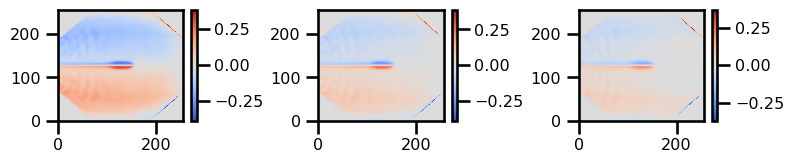

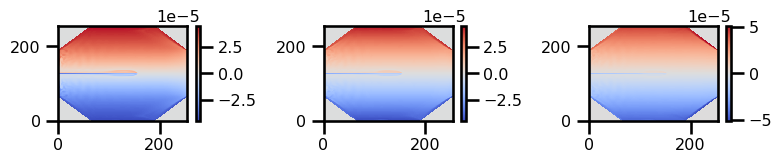

In [51]:
plot_field(sol.ys.psi[-1]/ (9.81 / params.f0))
plot_field(sol.ys.q[-1])

### Re-Run Simulation

In [52]:
%%time
# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(vector_field),
    solver=solver,
    t0=tmin,
    t1=tmax,
    dt0=dt,
    y0=State(sol.ys.q[-1], sol.ys.psi[-1]),
    saveat=saveat,
    args=None,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

CPU times: user 4min 46s, sys: 10.6 s, total: 4min 57s
Wall time: 3min 30s


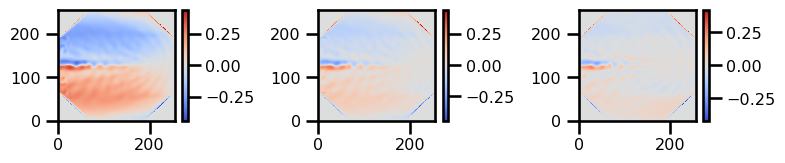

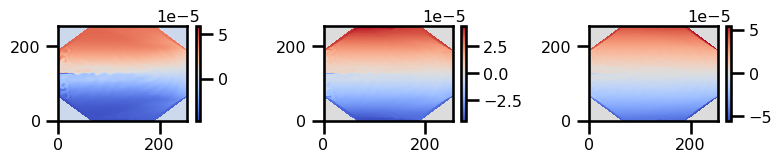

In [53]:
plot_field(sol.ys.psi[-1]/ (9.81 / params.f0))
plot_field(sol.ys.q[-1])